### RNN Model for Stock Analysis

1. import data from csv datsets
    - prices
    - sector and industry 
    - revenue
    - profit
2. compile into timestep sequence
3. create lagged y-value set
4. create model
    - lstm cell
    - dense layer
    - consider another lstm and dense layer
    - output
5. run model based on following inputs for each time step
    - market cap
    - industry (one-hot vector)
    - sector (one-hot vector)
    - revenue
    - profit
6. predict
    - run model up until the known value is done
    - iterate through following values feeding previous output and hidden state

#### Initialize definitions

In [1176]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

# using tensorflow.keras may be necessary, keras by itself may not work
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply, TimeDistributed, Reshape, Dropout
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K

In [1219]:
# define constants and filepaths

shareprices_path = 'raw/us-shareprices-daily.csv'
income_path = 'raw/us-income-ttm.csv'
# shareprices_path = 'us-shareprices-latest.csv' # latest data only, helps shorten load time while developing

MAX_DAYS = 9000 # number of total days possible for a stock
T_x = 5 # number of timesteps inputs
T_y = 1 # number of timestep outputs, T_x = T_y or 1, depending on the architecture
# n_a1 = 256 # number of hidden activation units in first LSTM layer
# n_a2 = 256 # number of hidden activation units in second LSTM layer
n_inputs = 5 # number of input variables per timestep
n_values = n_inputs # number of output predicted variables, may be same as n_inputs
n_trailing = T_x # number of trailing days used for prediction
n_forward = 360 # number of timesteps in advance for forward prediction
m = 10000 # number of training examples

sc = MinMaxScaler(feature_range=(1e-15,1)) # see https://stackoverflow.com/questions/49330195/how-to-use-inverse-transform-in-minmaxscaler-for-a-column-in-a-matrix for more on MinMaxScaler
sc2 = MinMaxScaler(feature_range=(1e-15,1))

#### Data Preparation

1. Import all datasets using pandas
2. Add market cap, revenue, profit, and yoy growth by quarter to dataset
    - Make data repeat until following quarter
3. Create a second dataset with sector of the company
4. Slice dataset into arrays of length T_x+1 and pair with sector

In [1178]:
def load_dataset(path, cols=None, delimiter=';'):
    
    """
    Loads a dataset from csv file into pandas dataframe.
    
    Parameters:
    path -- filepath to csv
    cols -- column labels to pass into reader, first label should be the date column label
    delimiter -- delimiter of values, default semicolon based on project data
    
    Returns:
    df -- dataframe with values from csv
    """
    
    df = pd.read_csv(path, delimiter=delimiter, usecols=cols)
    df.index = pd.to_datetime(df.pop(cols[0])) # alternatively, df.index = pd.to_datetime(df[cols[0]]); df = df.drop(columns=[cols[0]])
    df.index.name = 'Date' # renames column if date column originally has different name
    
    return df

In [1179]:
def clean_data(df, na=False, zeros=None, min_freq=1):
    
    """
    Removes rows with incomplete data, either NaN or zero values, based on specified columns.
    
    Parameters:
    df -- input dataframe
    na -- labels of columns to consider when removing rows with NaN values, default of False removes no rows (False instead of None because None removes all rows)
    zeros -- label of columns considered when removing rows with zero values, default of None removes no rows
    min_freq -- minimum number of rows of a ticker to remain in dataset, default of 1 removes no rows
    
    Returns:
    df -- dataframe with data cleaned
    """
    
    if na == 'all': na = df.columns[df.dtypes!='object'] # sets to columns with non-string dtypes
    if zeros == 'all': zeros = df.columns[df.dtypes!='object']
    
    if not na is False: df = df.dropna(subset=na) # removes all rows with NaN in specified columns, df.dropna(subset=[na], inplace=True) also works if SettingWithCopyWarning appears
    if not zeros is None: df = df[(df[zeros]!=0).all(axis=1)] # removes all rows with zero values in specified columns, see https://stackoverflow.com/a/22650162/6501621 and https://stackoverflow.com/questions/18172851/deleting-dataframe-row-in-pandas-based-on-column-value
    df = df[df.groupby('Ticker')['Ticker'].transform(len) >= min_freq] # removes all rows of a stock if stock has less than min_freq entries, see https://stackoverflow.com/a/48514338/6501621
    
    return df

In [1180]:
def add_derived_value(df, method, base_cols, deriv_cols, drop=False, group=None, periods=4):
    
    """
    Computes derived value based on method and parameters. Available derived values: percent change, multiplication.
    
    Parameters:
    df -- input dataframe (required)
    method -- computation to calculate derived values (required)
    base_cols -- list of column labels of base values used to compute derived values (required)
    deriv_cols -- list of column label(s) of derived values to add to dataframe (required)
    drop -- column label(s) to drop after computation (optional)
    group -- column label of grouping if necessary for calculation (optional)
    period -- number of periods between percent change calculation (optional)
    
    Returns:
    df -- dataframe with additional column(s) of derived calculations
    """
    
    # computes percentage change of base columns and adds to dataframe in new columns
    
    if method == 'pctchg':
        growth = lambda x: x.pct_change(periods=periods).fillna(method='backfill') # defines function to compute percent change and backfills missing data, replaced .backfill() with .fillna(method='backfill') for python version compatibility
        for base_col, deriv_col in zip(base_cols, deriv_cols): # loops through if applicable to multiple columns
            growth_col = df.groupby(group)[base_col].apply(growth) # applies function by group
            df[deriv_col] = growth_col # assigns derived values to specified column name
        
    # multiplies base columns together to create a new column
    
    elif method == 'multiply':
        multiply = df[base_cols[0]] # initializes variable
        for col in base_cols[1:]: multiply *= df[col] # loops through all other columns to multiply together into variable
        df[deriv_cols] = multiply # assigns derived values to specified column name, only one column can be specified in deriv_cols
        
    if drop: df = df.drop(columns=base_cols) # delete base columns after calculating derived values

    return df

In [1181]:
def access_ticker(df, ticker):
    
    """
    Returns the rows of a given ticker.
    
    Parameters:
    df -- input dataframe
    ticker -- stock ticker to retrieve values of
    
    Returns:
    df -- dataframe of rows of selected ticker
    """
    
    if len(df.index.names) <= 1: # access from single index
        return df[df['Ticker']==ticker]
    else: # access from MultiIndex
        return df.loc[ticker]

In [1182]:
def rescale_data_by_group(df, group, freq='1D'):
    
    """
    Rescales data from original frequency to specified frequency and forward fills empty rows if upscaling.
    
    Parameters:
    df -- input dataframe to rescale
    group -- column of grouping
    frequency -- frequency of data for each group
    """
    
    rescale = lambda x: x.asfreq(freq).fillna(method='pad') # defines function to rescale data to specified frequency, replaced .pad() with .fillna(method='pad') for python compatibility
    df = df.groupby(group).apply(rescale) # applies function by group
    df.pop(group) # df.drop provides same functionality for this use case
    df = df.reset_index(level=0)
    
    return df

In [1183]:
def generate_sequences(data, n_trailing=n_trailing, n_forward=n_forward):
    
    """
    Generates all sequences of input array given number of timesteps and length of forward projection.
    
    Parameters:
    data -- input array
    n_trailing -- number of timesteps used in sequence
    n_forward -- projection number of days in advance
    
    Return:
    sequences -- list of sequences generated from array
    """
    
    sequences = []
    
    for i in range(len(data)-n_trailing-n_forward+1):
        sequences.append(np.append(data[i:i+n_trailing], [data[i+n_trailing+n_forward-1]], axis=0)) # appends the n_trailing timesteps and timestep n_forward from most recent timestep
    
    return sequences

#### Loss Functions

In [1185]:
def custom_loss_function(loss, weights):
    
    """
    Computes a loss function with weighting on specific outputs.
    Based on https://keras.io/api/losses/
    https://towardsdatascience.com/how-to-create-a-custom-loss-function-keras-3a89156ec69b
    https://medium.com/@Bloomore/how-to-write-a-custom-loss-function-with-additional-arguments-in-keras-5f193929f7a0
    
    Parameters:
    loss -- loss options (mean squared error, mean absolute percentage error)
    weights -- list of loss weighting of output ['Market Cap', 'Revenue', 'Gross Profit', 'Net Income', 'YoY Revenue']
    
    Returns:
    custom_loss -- defines a custom error with loss weighting
    """
    
    loss_weights = K.constant(np.array([weights]))
    num_weights = np.sum(np.ones(len(weights))) # workaround because it seems multiplying by len(weights) directly doesn't work
    
    if loss == 'mse':
        def custom_loss(y_true, y_pred):
            loss = K.square(y_true - y_pred) # square before weighting losses, otherwise it gets messy
            weighted_loss = Multiply()([loss, loss_weights]) / np.sum(loss_weights) * num_weights # multiply by weights / sum of weights * num weights intuitively makes sense; the sum of (weights / sum of weights) = 1, so to recalibrate based on  original neutral weighting, multiply by length of weights (recalibration is unnecessary but nice)
            return K.mean(weighted_loss)
        
    elif loss == 'mape':
        def custom_loss(y_true, y_pred):
            diff = y_true - y_pred
            loss = 100 * K.abs(diff / y_true) # abs includes y_true because y_true may have negative values
            weighted_loss = Multiply()([loss, loss_weights]) / np.sum(loss_weights) * num_weights
            return K.mean(weighted_loss)
    
    return custom_loss

#### Other Functions

In [1210]:
def run_prediction(dataset, ticker, n_backtest, n_predictions, graph=True, col=0):
    
    """
    Generates continuous model output for a given stock based on specifications.
    Utilizes rolling previous predictions to continue forward predictions.
    
    Parameters:
    dataset -- input dataset
    ticker -- ticker of stock to predict
    n_backtest -- number of days before most recent time to start predictions
    n_predictions -- number of total predictions
    graph -- boolean, whether or not to plot a graph
    col -- column of output array to plot on graph
    
    Returns:
    output -- array of timesteps from the negative n_backtest steps forward n_prediction steps
    """

    data = dataset[ticker].copy()
    rolling_input = data[(-n_forward-n_trailing+1)-n_backtest:-n_backtest] # selects all timesteps necessary for n_backtest predictions to run, and then enough to continue in a cycle (i.e., n_trailing+n_forward-1)
    output = []
    for i in range(n_predictions):
        current_input = np.array(rolling_input[:n_trailing]) # selects the first n_trailing timesteps to make the next prediction
        current_input = current_input.reshape(1, *current_input.shape) # reshape into model input format
        output.append(model.predict(current_input).ravel())
        rolling_input[:-1] = rolling_input[1:] # shift one to the left
        rolling_input[-1:] = output[i]
    output = np.array(output)
    
    if graph:
        graph_output = np.append((dataset[ticker][:-n_backtest])[:, col], output[:, col]) # appends the true values and the predicted values
        graph_Y = (dataset[ticker])[:, col] # all true values

        max_range_true = len(dataset[ticker])-n_backtest # the furthest timestep designated for true values
        max_range_pred = max_range_true+n_predictions # the furthest timestep designated for predicted values

        plt.plot(graph_Y)
        plt.plot(np.arange(max_range_true), graph_output[np.arange(max_range_true)]) # plot all actual values
        plt.plot(np.arange(max_range_true-1, max_range_pred), graph_output[np.arange(max_range_true-1, max_range_pred)]) # plot all predicted values in different color
    
    return output

In [1211]:
def run_single_prediction(dataset, ticker, graph=True, col=0):
    
    """
    Generates model prediction one timestep at a time utilizing previous true values.
    Does not utilize predictions for further predictions.
    
    Parameters:
    dataset -- input dataset
    ticker -- ticker of stock to predict
    graph -- boolean, whether or not to plot a graph
    col -- column of output array to plot on graph 
    
    Returns:
    output -- all predicted values
    """
    
    data = np.array(generate_sequences(dataset[ticker]))[:, :-1]
    output = model.predict(data)
    
    if graph:
        graph_output = np.append((dataset[ticker][:n_trailing+n_forward-1])[:, col], output[:, col])
        Y = (dataset[ticker])[:, col]

        max_range_true = n_trailing + n_forward - 1 # the minimum number of timesteps of true values before predicted values
        max_range_pred = max_range_true + len(output) # maximum number of total timesteps, true and predicted

        plt.plot(Y)
        plt.plot(np.arange(max_range_true), graph_output[np.arange(max_range_true)]) # plot all actual values
        plt.plot(np.arange(max_range_true-1, max_range_pred), graph_output[np.arange(max_range_true-1, max_range_pred)]) # plot all predicted values in different color
    
    return output

In [1202]:
# consider using a data generator, see https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('data/' + ID + '.npy')

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [1184]:
def notify(title, text=""):
    
    """
    Displays a desktop notification with specified text.
    
    Parameters:
    title -- title of notification to be displayed
    text -- further details of notification
    
    Returns:
    None
    """
    
    os.system("""
              osascript -e 'display notification "{}" with title "{}"'
              """.format(text, title))

#### Data Processing

In [1186]:
# initialize income dataset

cols = ['Publish Date', 'Ticker', 'Revenue', 'Gross Profit', 'Net Income']
df_income = load_dataset(path=income_path, cols=cols)
df_income = clean_data(df_income, na='all', zeros='all', min_freq=5) # df_income.dtypes!='object'] is essentially everything except strings, don't forget it is '!=', not '=='
df_income = add_derived_value(df=df_income, method='pctchg', group='Ticker', base_cols=['Revenue'], deriv_cols=['YoY Revenue'], periods=4) # add YoY revenue column by calculating percent change
df_income = rescale_data_by_group(df_income, group='Ticker', freq='1D') # somehow turns 'Net Income' from int64 to float64?

In [1187]:
# initialize prices dataset

cols = ['Date', 'Ticker', 'Close', 'Shares Outstanding']
df_prices = load_dataset(path=shareprices_path, cols=cols)
df_prices = clean_data(df_prices, na='all', zeros='all')

In [1188]:
# compute marketcap and remove other variables

df_prices = add_derived_value(df=df_prices, method='multiply', base_cols=['Close', 'Shares Outstanding'], deriv_cols='Market Cap', group='Ticker', drop=True)
df_prices = df_prices[df_prices['Market Cap'] > 1e9] # only companies of value $1B or more

In [1189]:
# merge income and prices

df_main = df_prices.merge(df_income, on=['Ticker', 'Date'], how='inner') # inner means stock must be included in both pre-merge; if MultiIndex, the on=[] parameter determines order of pivot table
# assert not np.any(np.isnan(df_main))
assert not df_main.isna().any(None)

In [1190]:
# df_main = clean_data(df_main, min_freq=n_forward+1) # takes only those that are sizable enough, though if n_forward is under 365, unnecessary

In [1191]:
# # scale data

cols = df_main.columns[df_main.dtypes=='float64'] # ['Market Cap', 'Revenue', 'Gross Profit', 'Net Income', 'YoY Revenue']

sc = sc.fit(df_main[cols])
df_main[cols] = sc.transform(df_main[cols])

df_main[cols] = np.log(df_main[cols])

sc2.fit(df_main[cols]) # not sure if necessary but may be useful in reducing impact of columns such as YoY Revenue for instance
df_main[cols] = sc2.transform(df_main[cols])

In [1192]:
df_main

,Ticker,Market Cap,Revenue,Gross Profit,Net Income,YoY Revenue
Date,,,,,,
2014-03-27,GOOG,0.880509,0.938509,0.958657,0.973359,0.920496
2014-03-28,GOOG,0.880589,0.938509,0.958657,0.973359,0.920496
2014-03-31,GOOG,0.900680,0.938509,0.958657,0.973359,0.920496
2014-04-01,GOOG,0.901206,0.938509,0.958657,0.973359,0.920496
2014-04-02,GOOG,0.901198,0.938509,0.958657,0.973359,0.920496
...,...,...,...,...,...,...
2020-02-14,MAXR,0.674088,0.883497,0.908467,0.963075,0.920365
2020-02-18,MAXR,0.652219,0.883497,0.908467,0.963075,0.920365
2020-02-19,MAXR,0.638954,0.883497,0.908467,0.963075,0.920365


In [1193]:
# convert to list of numpy arrays

df_main = pd.pivot_table(df_main, index=['Ticker', 'Date']).reindex(columns=df_main.columns[1:]) # see https://stackoverflow.com/questions/36346071/pandas-pivot-table-changing-order-of-non-index-columns
export = lambda x: x.to_numpy()
dataset = df_main.groupby('Ticker').apply(export)

In [1194]:
# convert to training data format

full_dataset = []
for i, stock_data in enumerate(dataset[:500]):
    full_dataset += generate_sequences(stock_data) # see https://www.geeksforgeeks.org/python-ways-to-concatenate-two-lists/

In [1195]:
# convert to np array

full_data = np.asarray(full_dataset)
# np.save('saved/dataset', full_data)

In [1196]:
# load from npy file

# full_data = np.load('saved/dataset.npy')

In [1197]:
full_data.shape

(603879, 6, 5)

In [1221]:
indices = np.arange(len(full_data))
random.shuffle(indices)
X = full_data[indices[:m],:-1,:]
Y = full_data[indices[:m],-1:,:]
Y = Y.reshape(Y.shape[0], Y.shape[2])

#### Model Attempt 5

In [ ]:
# model = load_model('saved/weights_l1_180_15.h5')

In [1199]:
def model5_v1_1():
    
    """
    This model is based on model v5.1 but focuses on a single input (e.g., IPO price, or first datapoint).
    """
    
    X_input = Input(shape=(1, n_inputs))
    X = Dense(units=128, activation='relu')(X_input)
    X = Dense(units=128, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(units=128, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(units=64, activation='relu')(X)
    X = Dropout(0.2)(X)
    output = Dense(units=n_values, activation='linear')(X)
    
    model = Model(inputs=X_input, outputs=output)
    
    return model

In [1200]:
def model5_v1():
    
    """
    This model is based on model v4.1 but extends the input to 5 inputs and 5 outputs. Designed with a larger dataset
    in mind and additional computation power.
    """
    
    X_input = Input(shape=(T_x, n_inputs))
    X = LSTM(units=128, return_sequences=True)(X_input)
    X = TimeDistributed(Dense(units=256))(X)
    X = LSTM(units=256, return_sequences=True)(X)
    X = TimeDistributed(Dense(units=256))(X)
    X = LSTM(units=128)(X)
    X = Dropout(0.3)(X)
    X = Dense(units=128)(X)
    output = Dense(units=n_values)(X)
    
    model = Model(inputs=X_input, outputs=output)
    
    return model

In [1201]:
def model5():
    
    """
    This model is based on model v4.1 but extends the input to 5 inputs and 5 outputs. Designed with a larger dataset
    in mind and additional computation power.
    """
    
    X_input = Input(shape=(T_x, n_inputs))
    X = LSTM(units=128, return_sequences=True)(X_input)
    X = TimeDistributed(Dense(units=256))(X)
    X = LSTM(units=128)(X)
    X = Dropout(0.2)(X)
    X = Dense(units=128)(X)
    output = Dense(units=n_values)(X)
    
    model = Model(inputs=X_input, outputs=output)
    
    return model

In [1203]:
model = model5_v1()
model.compile(optimizer='adam', loss=custom_loss_function(loss='mse', weights=[2,1,1,1,1]), metrics=['mape']) # consider loss='msle' (mean squared logarithmic error, https://keras.io/api/losses/regression_losses/#meansquaredlogarithmicerror-class), or log during preprocessing (see https://stats.stackexchange.com/questions/213897/best-way-to-optimize-mape)

In [1222]:
model.fit(X, Y, batch_size=32, epochs=5)

Train on 10000 samples
Epoch 1/5
10000/10000 [==============================] - 22s 2ms/sample - loss: 0.0025 - mape: 4.4702
Epoch 2/5
10000/10000 [==============================] - 22s 2ms/sample - loss: 0.0014 - mape: 3.3163s - loss: 0.001
Epoch 3/5
10000/10000 [==============================] - 21s 2ms/sample - loss: 7.8576e-04 - mape: 2.4094
Epoch 4/5
10000/10000 [==============================] - 21s 2ms/sample - loss: 4.1704e-04 - mape: 1.6431
Epoch 5/5
10000/10000 [==============================] - 21s 2ms/sample - loss: 2.7305e-04 - mape: 1.1661


In [1205]:
notify("Model", "Model training complete")

In [1206]:
model.save('saved/weights_m2.h5', overwrite=False)

#### Output and Prediction

In [ ]:
# X2 = full_data[indices[m:m+0],:-1,:]
# Y2 = full_data[indices[m:m+0],-1:,:]
# Y2 = Y2.reshape(Y2.shape[0], Y2.shape[2])
model.evaluate(X, Y, verbose=0)

In [1208]:
# X3 = full_data[indices[1000],:-1,:]
# Y3 = full_data[indices[1000],-1:,:]
# print(sc.inverse_transform(model.predict(X3.reshape(1, *X3.shape))))
# print(sc.inverse_transform(X3))
# print(sc.inverse_transform(Y3))

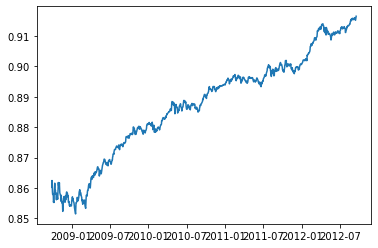

In [1224]:
plt.plot(access_ticker(df_main, 'AAPL')['Market Cap'][0:1000])

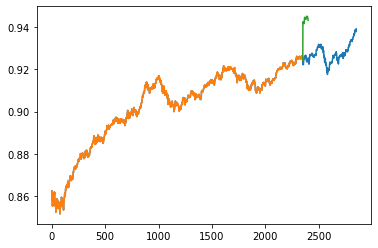

In [1225]:
output = run_prediction(dataset=dataset, ticker='AAPL', n_backtest=500, n_predictions=50)

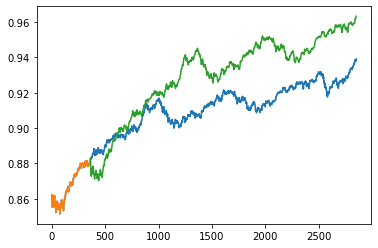

In [1226]:
ts_output = run_single_prediction(dataset=dataset, ticker='AAPL')

In [1214]:
notify("Model", "Model prediction complete")